# RNN에서 Seq2Seq로, 그리고 어텐션 메커니즘

In [23]:
import numpy as np 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import LSTM, Input, Concatenate
from tensorflow.keras.layers import Dense, Dot, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

cal_len = 15
# 문자와 인덱스 매핑
chars = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
num_classes = len(chars)

char_to_index = {char: idx for idx, char in enumerate(chars)}
index_to_char = {idx: char for idx, char in enumerate(chars)}
# 데이터 생성 함수
def generate_data(num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        sequence = np.random.choice(list(chars), cal_len)
        X.append([char_to_index[char] for char in sequence]) 
        y.append([char_to_index[char] for char in sequence[::-1]])
    return np.array(X), np.array(y)

# 학습 데이터 생성
num_samples = 20000
X, y = generate_data(num_samples)

# Reshape data
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [24]:
# 인코더 정의
encoder_inputs = Input(shape=(cal_len, 1))
encoder = LSTM(128, return_sequences=True,return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# 디코더 정의
decoder_inputs = Input(shape=(cal_len, 1))
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)


In [25]:
attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention = Activation('softmax')(attention)
context = Dot(axes=[2, 1])([attention, encoder_outputs])

decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context])

decoder_dense = Dense(52, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)


In [26]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 입력 데이터와 타겟 데이터를 동일하게 맞춤
decoder_input_data = np.zeros_like(X)


In [27]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit([X, decoder_input_data], y, epochs=50, validation_split=0.2, callbacks=[early_stopping])

def predict_reverse(input_sequence):
    input_sequence = np.array([char_to_index[char] for char in input_sequence]).reshape((1, cal_len, 1))    
    decoder_input = np.zeros((1, cal_len, 1))
    predicted_sequence = model.predict ([input_sequence, decoder_input])
    predicted_indices = np.argmax(predicted_sequence, axis=-1). reshape((cal_len,))
    return "".join([index_to_char[idx] for idx in predicted_indices])
    # return np.argmax(predicted_sequence, axis=-1). reshape((10,))

#검증용 문자열 리스트 (5글자짜리 30개)
test_strings = ["".join(np.random.choice(list(chars), cal_len)) for _ in range(30)]
# 실제 거꾸로 된 문자열 리스트
expected_outputs = [s[::-1] for s in test_strings]

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0402 - loss: 3.7954 - val_accuracy: 0.1685 - val_loss: 2.7649
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2247 - loss: 2.5278 - val_accuracy: 0.3411 - val_loss: 2.0581
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4032 - loss: 1.9537 - val_accuracy: 0.4991 - val_loss: 1.7005
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5213 - loss: 1.6358 - val_accuracy: 0.5681 - val_loss: 1.4691
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6123 - loss: 1.4164 - val_accuracy: 0.6638 - val_loss: 1.2855
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6774 - loss: 1.2521 - val_accuracy: 0.7132 - val_loss: 1.1531
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7231 - loss: 1.1189 - val_accuracy: 0.7547 - val_loss: 1.0368
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7650 - loss: 1.0128 - val_accu

In [28]:
correct_predictions = 0
total_predictions = len(test_strings)

for i, test_string in enumerate(test_strings):
    predicted_output = predict_reverse(test_string)
    is_correct = predicted_output == expected_outputs[i]
    
    if is_correct:
        correct_predictions += 1
        
    print(f"입력: {test_string}")
    print(f"예측된 출력: {predicted_output}")
    print(f"실제 출력: {expected_outputs[i]}")
    print(f"정확 여부: {'맞음' if is_correct else '틀림'}\n")

accuracy = correct_predictions / total_predictions
print(f"총 정확도: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
입력: NLpiqEZBCKuDUzc
예측된 출력: bzUDuKCBZEqipLO
실제 출력: czUDuKCBZEqipLN
정확 여부: 틀림

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
입력: iYDkLgFpnZbEdBx
예측된 출력: xBdEbZnpFgLkDYi
실제 출력: xBdEbZnpFgLkDYi
정확 여부: 맞음

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
입력: cCLFTdOBhsSvmMP
예측된 출력: PMmvSshBOdTFLCc
실제 출력: PMmvSshBOdTFLCc
정확 여부: 맞음

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
입력: AwUlYgXMlmUChQx
예측된 출력: yQhCUmlMXgYlUwA
실제 출력: xQhCUmlMXgYlUwA
정확 여부: 틀림

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
입력: FLkDwDwfSQuunpg
예측된 출력: gpnuvQSfwDwDkLF
실제 출력: gpnuuQSfwDwDkLF
정확 여부: 틀림

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
입력: jMtiDVrtEAhznPf
예측된 출력: fPnzhAEtrVDitMj
실제 출력: fPnzhAEtrVDitMj
정확 여부: 맞음

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
입력: snrHyFScLOMlvdg
예측된 출력: gdvlMOLcSFyHrnt
실제 출력: gdvlMOLcSFyHrns
정확 여부: 틀림

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
입력: HcprloYkBqUEbFp
예측된 출력: pFbEUqBkYolrpcG
실제 출력: pFbEUqBkYolrpcH
정확 여부: 틀림

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
입력: NHyYxKTkrJNwTuq
예측된 출력: quTwNJrk

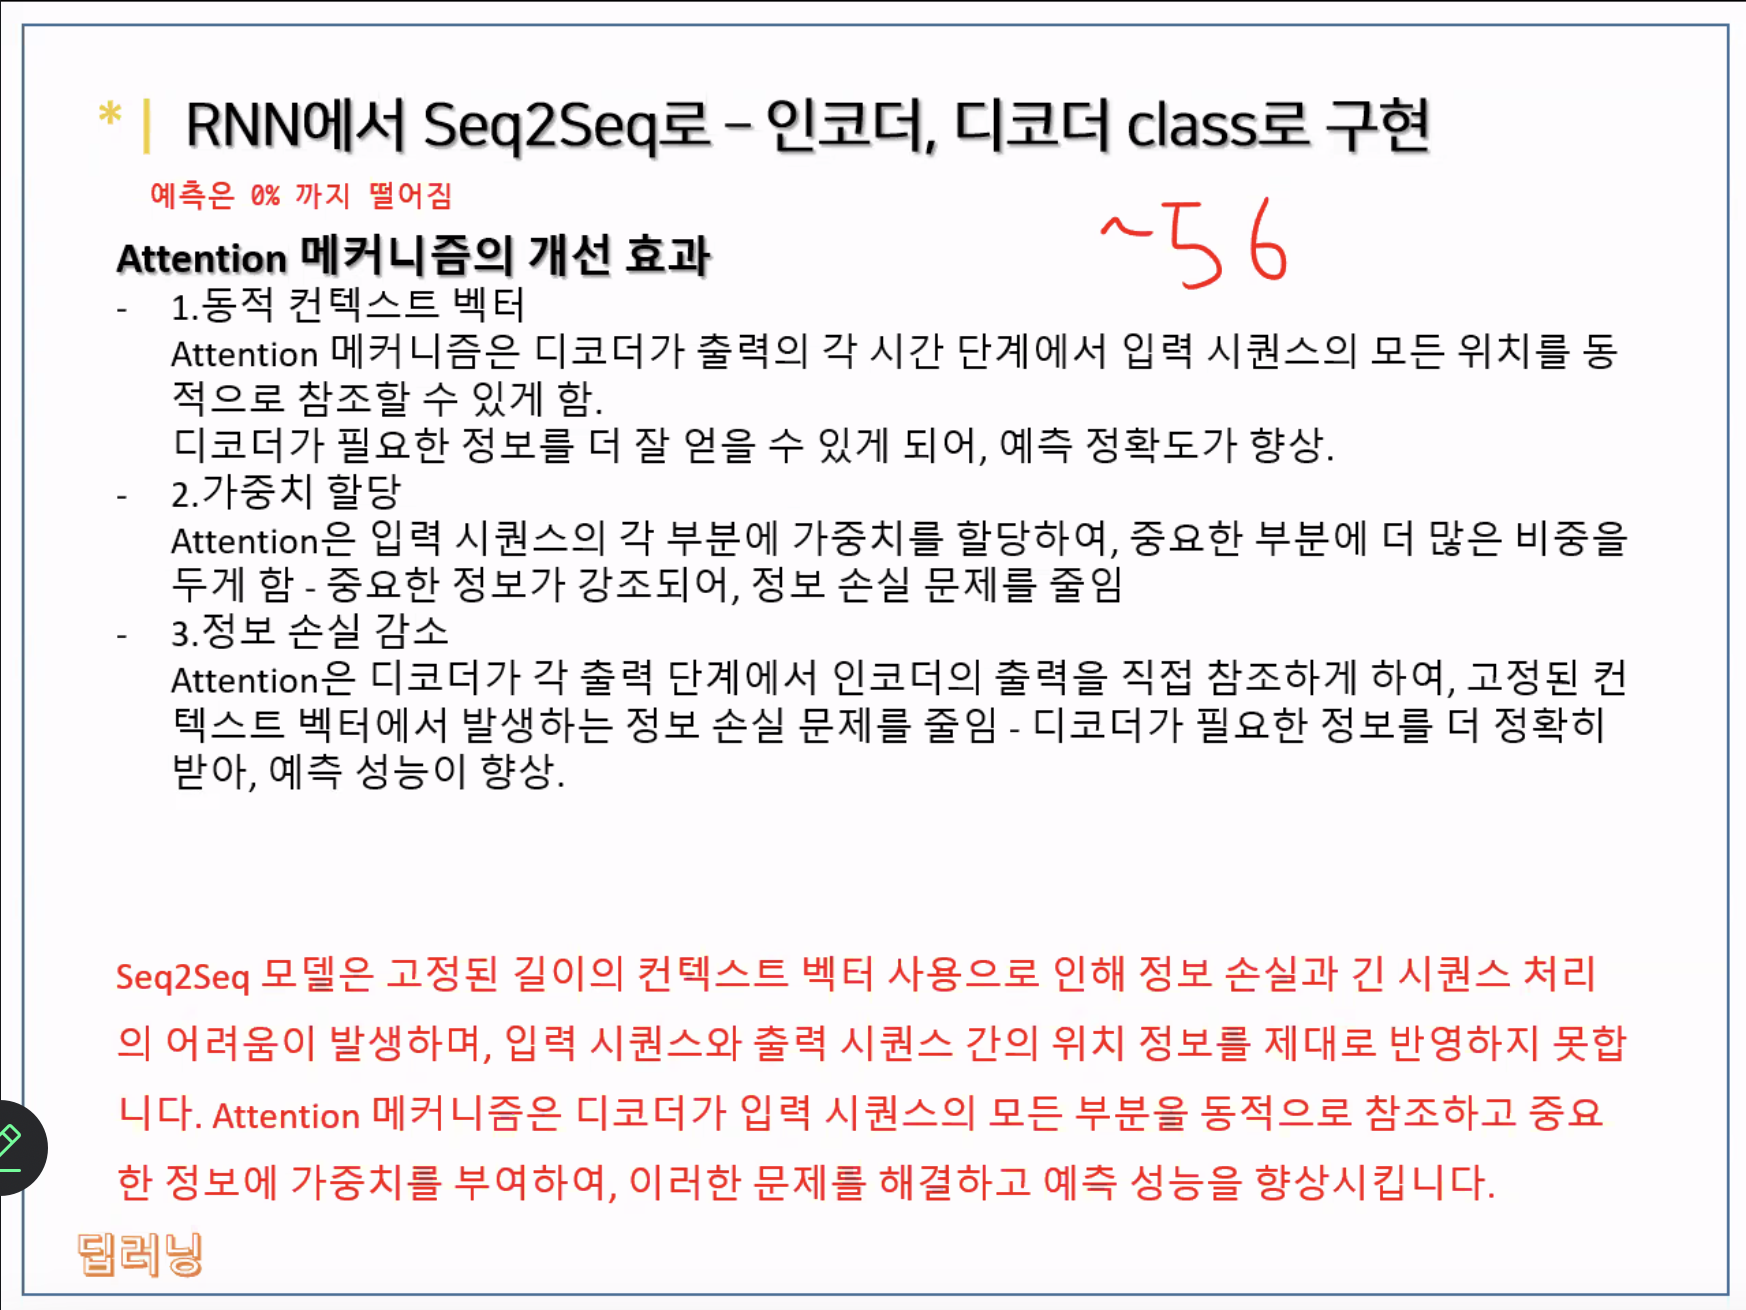